**Learning Objectives**

 1. Practice defining and performing basic operations on constant Tensors
 2. Use Tensorflow's automatic differentiation capability
 3. Learn how to train a linear regression from scratch with TensorFLow


## Introduction 

In this notebook, we will start by reviewing the main operations on Tensors in TensorFlow and understand how to manipulate TensorFlow Variables. We explain how these are compatible with python built-in list and numpy arrays. 

Then we will jump to the problem of training a linear regression from scratch with gradient descent. The first order of business will be to understand how to compute the gradients of a function (the loss here) with respect to some of its arguments (the model weights here). The TensorFlow construct allowing us to do that is `tf.GradientTape`, which we will describe. 

At last we will create a simple training loop to learn the weights of a 1-dim linear regression using synthetic data generated from a linear model. 

As a bonus exercise, we will do the same for data generated from a non linear model, forcing us to manual engineer non-linear features to improve our linear model performance.

Each learning objective will correspond to a __#TODO__  in this student lab notebook -- try to complete this notebook first and then review the [solution notebook](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/introduction_to_tensorflow/solutions/write_low_level_code.ipynb)


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

### Variables and Constants

Tensors in TensorFlow are either contant (`tf.constant`) or variables (`tf.Variable`).
Constant values can not be changed, while variables values can be.

The main difference is that instances of `tf.Variable` have methods allowing us to change 
their values while tensors constructed with `tf.constant` don't have these methods, and
therefore their values can not be changed. When you want to change the value of a `tf.Variable`
`x` use one of the following method: 

* `x.assign(new_value)`
* `x.assign_add(value_to_be_added)`
* `x.assign_sub(value_to_be_subtracted`

In [2]:
y = tf.constant([2,3,4])

In [3]:
y

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([2, 3, 4], dtype=int32)>

In [4]:
x = tf.Variable(2.0, dtype = tf.float32, name = 'my_variable')

In [5]:
x

<tf.Variable 'my_variable:0' shape=() dtype=float32, numpy=2.0>

In [6]:
x.assign(5.0)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=5.0>

In [7]:
x.assign_add(4)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=9.0>

In [8]:
x.assign_sub(4)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=5.0>

### Point-wise operations

Tensorflow offers similar point-wise tensor operations as numpy does:
    
* `tf.add` allows to add the components of a tensor 
* `tf.multiply` allows us to multiply the components of a tensor
* `tf.subtract` allow us to substract the components of a tensor
* `tf.math.*` contains the usual math operations to be applied on the components of a tensor
* and many more...

Most of the standard arithmetic operations (`tf.add`, `tf.substrac`, etc.) are overloaded by the usual corresponding arithmetic symbols (`+`, `-`, etc.)

In [9]:
import tensorflow as tf
a = tf.Variable([3.0, 1.0, 5.0])
b = tf.Variable([5.0, 1.0, 5.0])
c = a+b
d = tf.add(a,b)

print("c:", c)
print("d:", d)

c: tf.Tensor([ 8.  2. 10.], shape=(3,), dtype=float32)
d: tf.Tensor([ 8.  2. 10.], shape=(3,), dtype=float32)


In [10]:
import tensorflow as tf
# tf.math.exp expects floats so we need to explicitly give the type
a = tf.Variable([7.0, 1.0, 8.0])
b = tf.math.exp(a)

print("b:", b)

b: tf.Tensor([1.0966332e+03 2.7182817e+00 2.9809580e+03], shape=(3,), dtype=float32)


### NumPy Interoperability

In addition to native TF tensors, tensorflow operations can take native python types and NumPy arrays as operands. 

In [11]:
# native python list
a_py = [1, 2] 
b_py = [3, 4] 

In [12]:
tf.add(a_py, b_py)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([4, 6], dtype=int32)>

In [13]:
# numpy arrays
a_np = np.array([1, 2])
b_np = np.array([3, 4])

In [14]:
tf.add(a_np, b_np)

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([4, 6])>

In [15]:
# native TF tensor
a_tf = tf.constant([1, 2])
b_tf = tf.constant([3, 4])

In [16]:
tf.add(a_tf, b_tf)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([4, 6], dtype=int32)>

In [17]:
a_tf.numpy()

array([1, 2], dtype=int32)

## Linear Regression

Now let's use low level tensorflow operations to implement linear regression.

Later in the course you'll see abstracted ways to do this using high level TensorFlow.

### Toy Dataset

We'll model the following function:

\begin{equation}
y= 2x + 10
\end{equation}

In [18]:
X = tf.constant(range(10), dtype=tf.float32)
Y = 2 * X + 10

print("X:{}".format(X))
print("Y:{}".format(Y))

X:[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Y:[10. 12. 14. 16. 18. 20. 22. 24. 26. 28.]


In [19]:
X_test = tf.constant(range(10, 20), dtype=tf.float32)
Y_test = 2 * X_test + 10

print("X_test:{}".format(X_test))
print("Y_test:{}".format(Y_test))

X_test:[10. 11. 12. 13. 14. 15. 16. 17. 18. 19.]
Y_test:[30. 32. 34. 36. 38. 40. 42. 44. 46. 48.]


#### Loss Function

In [20]:
y_mean = Y.numpy().mean()
print(y_mean)
def predict_mean(X):
    y_hat = [y_mean] * len(X)
    print(y_hat)
    return y_hat

Y_hat = predict_mean(X_test)

19.0
[19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0]


Using mean squared error, our loss is:
\begin{equation}
MSE = \frac{1}{m}\sum_{i=1}^{m}(\hat{Y}_i-Y_i)^2
\end{equation}

In [21]:
errors = (Y_hat - Y)**2
print(errors.numpy().sum()/10)
loss = tf.reduce_mean(errors)
loss.numpy()

33.0


33.0

This values for the MSE loss above will give us a baseline to compare how a more complex model is doing.

Now, if $\hat{Y}$ represents the vector containing our model's predictions when we use a linear regression model
\begin{equation}
\hat{Y} = w_0X + w_1
\end{equation}

we can write a loss function taking as arguments the coefficients of the model:

In [22]:
def loss_mse(X, Y, w0, w1):
    Y_hat = w0 * X + w1
    errors = (Y_hat - Y)**2
    return tf.reduce_mean(errors)

### Gradient Function

To use gradient descent we need to take the partial derivatives of the loss function with respect to each of the weights. We could manually compute the derivatives, but with Tensorflow's automatic differentiation capabilities we don't have to!

During gradient descent we think of the loss as a function of the parameters $w_0$ and $w_1$. Thus, we want to compute the partial derivative with respect to these variables. 

For that we need to wrap our loss computation within the context of `tf.GradientTape` instance which will record gradient information:

```python
with tf.GradientTape() as tape:
    loss = # computation 
```

This will allow us to later compute the gradients of any tensor computed within the `tf.GradientTape` context with respect to instances of `tf.Variable`:

```python
gradients = tape.gradient(loss, [w0, w1])
```

In [23]:
x = tf.Variable(3.0)

with tf.GradientTape() as tape:
    y = x**2

In [24]:
# dy = 2x * dx
dy_dx = tape.gradient(y, x)
dy_dx.numpy()

6.0

In [25]:
w = tf.Variable(tf.random.normal((3, 2)), name='w')
print(w)
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
print(b)
x = [[1., 2., 3.]]

with tf.GradientTape(persistent=True) as tape:
    y = x @ w + b
    loss = tf.reduce_mean(y**2)

<tf.Variable 'w:0' shape=(3, 2) dtype=float32, numpy=
array([[ 0.21893696, -0.0045521 ],
       [ 1.1511766 ,  0.70551634],
       [-1.7533406 ,  1.6243577 ]], dtype=float32)>
<tf.Variable 'b:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>


In [26]:
[dl_dw, dl_db] = tape.gradient(loss, [w, b])

In [27]:
print(w.shape)
print(w)
print(dl_dw.shape)
print(dl_dw)

(3, 2)
<tf.Variable 'w:0' shape=(3, 2) dtype=float32, numpy=
array([[ 0.21893696, -0.0045521 ],
       [ 1.1511766 ,  0.70551634],
       [-1.7533406 ,  1.6243577 ]], dtype=float32)>
(3, 2)
tf.Tensor(
[[-2.7387316  6.2795534]
 [-5.4774632 12.559107 ]
 [-8.216195  18.838661 ]], shape=(3, 2), dtype=float32)


In [28]:
my_vars = {
    'w': w,
    'b': b
}

grad = tape.gradient(loss, my_vars
                    )
grad['b']

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-2.7387316,  6.2795534], dtype=float32)>

## Gradients with respect to a model
It's common to collect tf.Variables into a tf.Module or one of its subclasses (layers.Layer, keras.Model) for checkpointing and exporting.

In most cases, you will want to calculate gradients with respect to a model's trainable variables. Since all subclasses of tf.Module aggregate their variables in the Module.trainable_variables property, you can calculate these gradients in a few lines of code:




In [29]:
layer = tf.keras.layers.Dense(2, activation='relu')
x = tf.constant([[1., 2., 3.]])

with tf.GradientTape() as tape:
  # Forward pass
  y = layer(x)
  loss = tf.reduce_mean(y**2)

# Calculate gradients with respect to every trainable variable
grad = tape.gradient(loss, layer.trainable_variables)

In [30]:
for var, g in zip(layer.trainable_variables, grad):
  print(f'{var.name}, shape: {g.shape}')

dense/kernel:0, shape: (3, 2)
dense/bias:0, shape: (2,)


In [31]:
## for var, g in zip(layer.trainable_variables, grad):
print(f'{var.name}, shape: {g.shape}')

dense/bias:0, shape: (2,)


## Controlling what the tape watches
The default behavior is to record all operations after accessing a trainable tf.Variable. The reasons for this are:

<li>The tape needs to know which operations to record in the forward pass to calculate the gradients in the backwards pass.
<li>The tape holds references to intermediate outputs, so you don't want to record unnecessary operations.
<li>The most common use case involves calculating the gradient of a loss with respect to all a model's trainable variables.
For example, the following fails to calculate a gradient because the tf.Tensor is not "watched" by default, and the tf.Variable is not trainable:

In [32]:
# A trainable variable
x0 = tf.Variable(3.0, name='x0')
# Not trainable
x1 = tf.Variable(3.0, name='x1', trainable=False)
# Not a Variable: A variable + tensor returns a tensor.
x2 = tf.Variable(2.0, name='x2') + 1.0
print(x2)
# Not a variable
x3 = tf.constant(3.0, name='x3')

with tf.GradientTape() as tape:
    y = (x0**2) + (x1**2) + (x2**2)

grad = tape.gradient(y, [x0, x1, x2, x3])

for g in grad:
    print(g)

tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)
None
None
None


In [33]:
[var.name for var in tape.watched_variables()]

['x0:0']

In [34]:
x = tf.constant(3.0)
with tf.GradientTape() as tape:
    tape.watch(x)
    y = x**2

# dy = 2x * dx
dy_dx = tape.gradient(y, x)
print(dy_dx.numpy())
#tf.GradientTape provides hooks that give the user control over what is or is not watched.

#To record gradients with respect to a tf.Tensor, you need to call GradientTape.watch(x):




6.0


In [35]:
x0 = tf.Variable(0.0)
x1 = tf.Variable(10.0)

with tf.GradientTape(watch_accessed_variables=False) as tape:
  tape.watch(x1)
  y0 = tf.math.sin(x0)
  y1 = tf.nn.softplus(x1)
  y = y0 + y1
  ys = tf.reduce_sum(y)
  print(y0)

tf.Tensor(0.0, shape=(), dtype=float32)


In [36]:
# dys/dx1 = exp(x1) / (1 + exp(x1)) = sigmoid(x1)
grad = tape.gradient(ys, {'x0': x0, 'x1': x1})

print('dy/dx0:', grad['x0'])
print('dy/dx1:', grad['x1'].numpy())

dy/dx0: None
dy/dx1: 0.9999546


## Intermediate results
You can also request gradients of the output with respect to intermediate values computed inside the tf.GradientTape context.

In [37]:
x = tf.constant(3.0)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = x * x
  z = y * y

# Use the tape to compute the gradient of z with respect to the
# intermediate value y.
# dz_dy = 2 * y and y = x ** 2 = 9
print(tape.gradient(z, y).numpy())

18.0


By default, the resources held by a GradientTape are released as soon as the GradientTape.gradient method is called. To compute multiple gradients over the same computation, create a gradient tape with persistent=True. This allows multiple calls to the gradient method as resources are released when the tape object is garbage collected. For example:

In [38]:
x = tf.constant([1, 3.0])
with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  y = x * x
  z = y * y

print(tape.gradient(z, x).numpy())  # [4.0, 108.0] (4 * x**3 at x = [1.0, 3.0])
print(tape.gradient(y, x).numpy())  # [2.0, 6.0] (2 * x at x = [1.0, 3.0])

[  4. 108.]
[2. 6.]


In [39]:
del tape   # Drop the reference to the tape

## Gradients of non-scalar targets
A gradient is fundamentally an operation on a scalar.

In [40]:
x = tf.Variable(2.0)
with tf.GradientTape(persistent=True) as tape:
  y0 = x**2
  y1 = 1 / x

print(tape.gradient(y0, x).numpy())
print(tape.gradient(y1, x).numpy())

4.0
-0.25


In [41]:
x = tf.Variable(2.0)
with tf.GradientTape() as tape:
  y0 = x**2
  y1 = 1 / x

print(tape.gradient({'y0': y0, 'y1': y1}, x).numpy()) # toplamini verdi

3.75


In [42]:
x = tf.Variable(2.)

with tf.GradientTape() as tape:
  y = x * [3., 4.]

print(tape.gradient(y, x).numpy())

7.0


In [43]:
x = tf.linspace(-10.0, 10.0, 200+1)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = tf.nn.sigmoid(x)

dy_dx = tape.gradient(y, x)

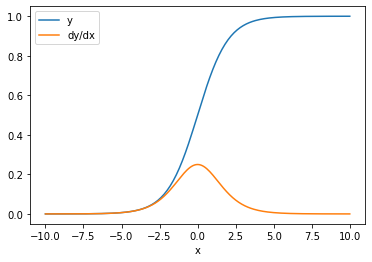

In [44]:
plt.plot(x, y, label='y')
plt.plot(x, dy_dx, label='dy/dx')
plt.legend()
_ = plt.xlabel('x')

In [45]:
x = tf.Variable(2.)
y = tf.Variable(3.)

with tf.GradientTape() as tape:
  z = y * y
print(tape.gradient(z, x))

None


In [46]:
# Replaced a variable with a tensor

In [47]:
x = tf.Variable(2.0)

for epoch in range(2):
  with tf.GradientTape() as tape:
    y = x+1

  print(type(x).__name__, ":", tape.gradient(y, x))
  x = x + 1   # This should be `x.assign_add(1)`

ResourceVariable : tf.Tensor(1.0, shape=(), dtype=float32)
EagerTensor : None


In [48]:
# Did calculations outside of TensorFlow
x = tf.Variable([[1.0, 2.0],
                 [3.0, 4.0]], dtype=tf.float32)

with tf.GradientTape() as tape:
    x2 = x**2
    print(x2)
    

  # This step is calculated with NumPy
    y = np.mean(x2, axis=0)
    print(y)
  # Like most ops, reduce_mean will cast the NumPy array to a constant tensor
  # using `tf.convert_to_tensor`.
    y = tf.reduce_mean(y, axis=0)
    print(y)

print(tape.gradient(y, x))

tf.Tensor(
[[ 1.  4.]
 [ 9. 16.]], shape=(2, 2), dtype=float32)
[ 5. 10.]
tf.Tensor(7.5, shape=(), dtype=float32)
None


In [49]:
# Zeros instead of None
x = tf.Variable([2., 2.])
y = tf.Variable(3.)

with tf.GradientTape() as tape:
  z = y**2
print(tape.gradient(z, x, unconnected_gradients=tf.UnconnectedGradients.ZERO))

tf.Tensor([0. 0.], shape=(2,), dtype=float32)


In [50]:
X = tf.constant(np.linspace(0, 2, 1000), dtype=tf.float32)
Y = X * tf.exp(-X**2)

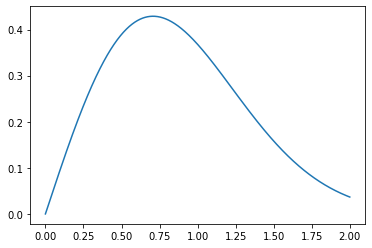

In [51]:
%matplotlib inline

plt.plot(X, Y)

In [52]:
def make_features(X):
    f1 = tf.ones_like(X)  # Bias.
    f2 = X
    f3 = tf.square(X)
    f4 = tf.sqrt(X)
    f5 = tf.exp(X)
    return tf.stack([f1, f2, f3, f4, f5], axis=1)

In [53]:
tensor = tf.constant([[1, 2, 3], [4, 5, 6]])
tf.ones_like(tensor)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

In [54]:
def predict(X, W):
    return tf.squeeze(X @ W, -1)

In [55]:
def loss_mse(X, Y, W):
    Y_hat = predict(X, W)
    errors = (Y_hat - Y)**2
    return tf.reduce_mean(errors)

In [56]:
def compute_gradients(X, Y, W):
    with tf.GradientTape() as tape:
        loss = loss_mse(Xf, Y, W)
    return tape.gradient(loss, W)

STEP: 2000 MSE: 0.002376794582232833


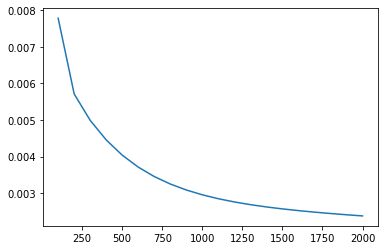

In [57]:
STEPS = 2000
LEARNING_RATE = .02


Xf = make_features(X)
n_weights = Xf.shape[1]

W = tf.Variable(np.zeros((n_weights, 1)), dtype=tf.float32)

# For plotting
steps, losses = [], []
plt.figure()


for step in range(1, STEPS + 1):

    dW = compute_gradients(X, Y, W)
    W.assign_sub(dW * LEARNING_RATE)

    if step % 100 == 0:
        loss = loss_mse(Xf, Y, W)
        steps.append(step)
        losses.append(loss)
        plt.clf()
        plt.plot(steps, losses)


print("STEP: {} MSE: {}".format(STEPS, loss_mse(Xf, Y, W)))

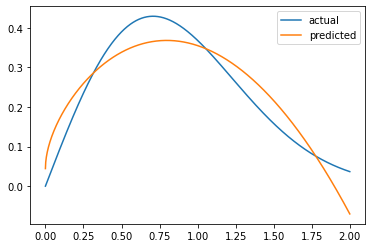

In [58]:
# The .figure() method will create a new figure, or activate an existing figure.
plt.figure()
# The .plot() is a versatile function, and will take an arbitrary number of arguments. For example, to plot x versus y.
plt.plot(X, Y, label='actual')
plt.plot(X, predict(Xf, W), label='predicted')
# The .legend() method will place a legend on the axes.
plt.legend()

In [59]:
# Create example data
data = {
    'Age': 29,
    'Movie': ['The Shawshank Redemption', 'Fight Club'],
    'Movie Ratings': [9.0, 9.7],
    'Suggestion': 'Inception',
    'Suggestion Purchased': 1.0,
    'Purchase Price': 9.99
}

print(data)

{'Age': 29, 'Movie': ['The Shawshank Redemption', 'Fight Club'], 'Movie Ratings': [9.0, 9.7], 'Suggestion': 'Inception', 'Suggestion Purchased': 1.0, 'Purchase Price': 9.99}


In [60]:
# Create the Example
example = tf.train.Example(features=tf.train.Features(feature={
    'Age': tf.train.Feature(
        int64_list=tf.train.Int64List(value=[data['Age']])),
    'Movie': tf.train.Feature(
        bytes_list=tf.train.BytesList(
            value=[m.encode('utf-8') for m in data['Movie']])),
    'Movie Ratings': tf.train.Feature(
        float_list=tf.train.FloatList(value=data['Movie Ratings'])),
    'Suggestion': tf.train.Feature(
        bytes_list=tf.train.BytesList(
            value=[data['Suggestion'].encode('utf-8')])),
    'Suggestion Purchased': tf.train.Feature(
        float_list=tf.train.FloatList(
            value=[data['Suggestion Purchased']])),
    'Purchase Price': tf.train.Feature(
        float_list=tf.train.FloatList(value=[data['Purchase Price']]))
}))

print(example)

features {
  feature {
    key: "Age"
    value {
      int64_list {
        value: 29
      }
    }
  }
  feature {
    key: "Movie"
    value {
      bytes_list {
        value: "The Shawshank Redemption"
        value: "Fight Club"
      }
    }
  }
  feature {
    key: "Movie Ratings"
    value {
      float_list {
        value: 9.0
        value: 9.699999809265137
      }
    }
  }
  feature {
    key: "Purchase Price"
    value {
      float_list {
        value: 9.989999771118164
      }
    }
  }
  feature {
    key: "Suggestion"
    value {
      bytes_list {
        value: "Inception"
      }
    }
  }
  feature {
    key: "Suggestion Purchased"
    value {
      float_list {
        value: 1.0
      }
    }
  }
}



In [61]:
#Write TFrecord file
with tf.python_io.TFRecordWriter('customer_1.tfrecord') as writer:
    writer.write(example.SerializeToString())

AttributeError: module 'tensorflow' has no attribute 'python_io'

In [ ]:
# Read and print data:
sess = tf.InteractiveSession()

# Read TFRecord file
reader = tf.TFRecordReader()
filename_queue = tf.train.string_input_producer(['customer_1.tfrecord'])

_, serialized_example = reader.read(filename_queue)

# Define features
read_features = {
    'Age': tf.FixedLenFeature([], dtype=tf.int64),
    'Movie': tf.VarLenFeature(dtype=tf.string),
    'Movie Ratings': tf.VarLenFeature(dtype=tf.float32),
    'Suggestion': tf.FixedLenFeature([], dtype=tf.string),
    'Suggestion Purchased': tf.FixedLenFeature([], dtype=tf.float32),
    'Purchase Price': tf.FixedLenFeature([], dtype=tf.float32)}

# Extract features from serialized data
read_data = tf.parse_single_example(serialized=serialized_example,
                                    features=read_features)

# Many tf.train functions use tf.train.QueueRunner,
# so we need to start it before we read
tf.train.start_queue_runners(sess)

# Print features
for name, tensor in read_data.items():
    print('{}: {}'.format(name, tensor.eval()))